# Pollution: sanity checks and first application
---
Simon Zabrocki.


This notebook illustrates how the variational model can be used to create realistic pollution data. Note that this is a simple example to check that the model works well on continous data.

In [1]:
import os
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

In [2]:
import pandas as pd
from torch import nn
import numpy as np
import torch
import pytorch_lightning as pl
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use('ggplot')


from src.utils import get_train_val_loaders_X_C_Y
from src.model import VariationnalModel
from src.sampling import sample_X_given_y_and_c


## Data Processing

In [3]:
def process_pollution_data(path='data/pollution/marseille.csv'):

    variables = ['date', 'season',  'mean_no2_l', 'mean_o3_l', 
                 'mean_pm25_l', 'mean_pm10_l', 'mean_so2_l',
                 'mean_no2_sl', 'mean_pm10_sl','temperature_average', 
                 'humidity_average', 'wind_speed',
                 "wind_u", "wind_v"]

    data = pd.read_csv(path, parse_dates=['date'], usecols=variables)

    scaler = StandardScaler()

    data = pd.DataFrame(scaler.fit_transform(data.set_index(['date', 'season'])),
                 columns=data.set_index(['date', 'season']).columns,
                ).assign(date=data.date, season=data.season)

    columns_order = data.drop(columns=['date', 'season']).columns

    data = (
        data.assign(year=data.date.dt.year)
           .assign(month=data.date.dt.month)
           .assign(day=data.date.dt.day)
           .assign(weekday=data.date.dt.weekday)
           .assign(hour=data.date.dt.hour)
           .pivot(index=['year', 'season', 'month', 'day', 'weekday'], columns=['hour'])   
           .reset_index()
    )
    
    return data, scaler, columns_order

data, scaler, columns_order = process_pollution_data()

X = data.drop(columns=['date', 'year', 'season', 'month', 'month', 'day', 'weekday'])
C = pd.get_dummies(data[['season', 'month', 'weekday']].astype(str)).values


/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4152: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


## Model Training

In [4]:
train_loader, val_loader = get_train_val_loaders_X_C_Y(X=X.values, Y=None, C=C, shuffle=True)

model_arguments = {
    'X_shape': X.shape[-1],
    'C_shape': C.shape[-1],
    'latent_shape': 24,
    'activation': nn.ReLU(),
    'hidden_shapes': [100, 50],
    'learning_rate': 1e-2,
    'alpha': 32,
    'beta': 10,
    'gamma': 0,
    'X_continuous_shape': X.shape[-1],
    'X_categorical_shape':0,
    'X_categorical_n_classes':0,
    "y_continuous_shape": 0,
    "y_categorical_shape": 0,
    'y_categorical_n_classes':0,
}

autoencoder = VariationnalModel(**model_arguments)

In [5]:
autoencoder

VariationnalModel(
  (encoder): MultiLayerModule(
    (module): Sequential(
      (dense_layer_1): Linear(in_features=311, out_features=100, bias=True)
      (batch_norm_1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_1): ReLU()
      (dense_layer_2): Linear(in_features=100, out_features=50, bias=True)
      (batch_norm_2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_2): ReLU()
      ((z_mean_logvar)_(y_mean_logvar)_(classification_logits)): Linear(in_features=50, out_features=48, bias=True)
    )
  )
  (decoder): MultiLayerModule(
    (module): Sequential(
      (dense_layer_1): Linear(in_features=47, out_features=50, bias=True)
      (batch_norm_1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_1): ReLU()
      (dense_layer_2): Linear(in_features=50, out_features=100, bias=True)
      (batch_norm_2): BatchNorm1d(100, eps=1e-0

In [6]:
trainer = pl.Trainer(max_epochs=12)

trainer.fit(autoencoder, train_dataloader=train_loader, val_dataloaders=val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type             | Params
---------------------------------------------
0 | encoder | MultiLayerModule | 38 K  
1 | decoder | MultiLayerModule | 65 K  


1

## Simulations and Sampling

In [7]:
def format_data(data, scaler=scaler, columns_order=columns_order):
    data = data.copy()
    data = data.melt(id_vars=[('season', ''), ('month', ''), ('day', ''), ('year', '')], var_name=['variable', 'hour'])
    data.columns = ['season', 'month', 'day', 'year', 'variable', 'hour', 'value']
    data['date'] = pd.to_datetime(dict(year=data.year, month=data.month, day=data.day, hour=data.hour))
    data = data.pivot(index=['season', 'month', 'day', 'year', 'hour', 'date'], columns=['variable'], values='value')
    
    data = pd.DataFrame(scaler.inverse_transform(data[columns_order]), columns=columns_order, index=data.index)
    return data


In [8]:
X_sample = sample_X_given_y_and_c(autoencoder,
                                  y=torch.empty(size=(C.shape[0], 0)),
                                  c=torch.tensor(C).float(),
                                  center_z=False,
                                  mean_continuous=True)

sampled_data = pd.DataFrame(X_sample, columns=X.columns).merge(data[['season', 'month', 'day', 'year']], left_index=True, right_index=True)
sampled_data = format_data(sampled_data)

original_data = format_data(data.drop(columns=['date']))

all_data = pd.concat([sampled_data.assign(type='sampled'), original_data.assign(type='original')], axis=0)

/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4152: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


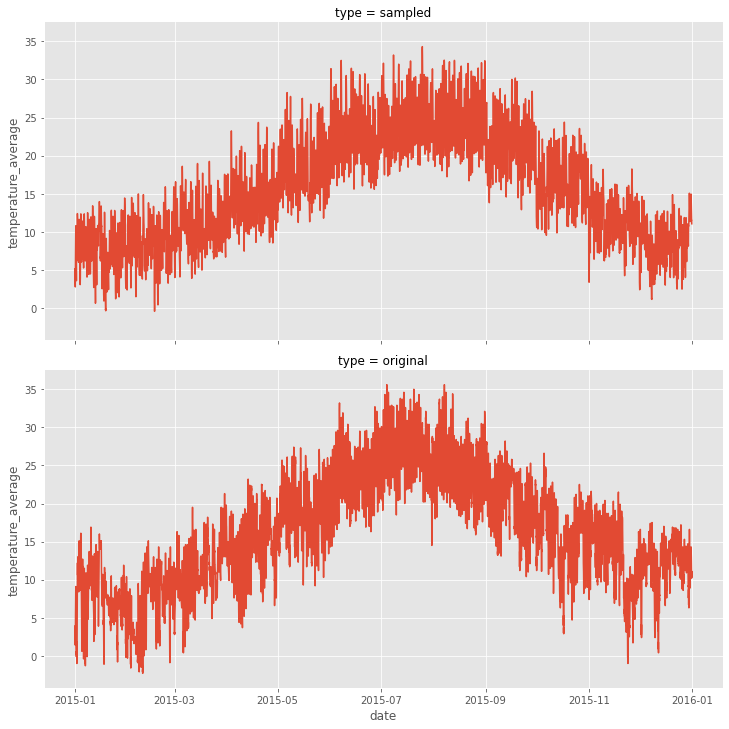

In [9]:
sns.relplot(data=all_data.query("year==2015").reset_index(),
            x="date", y="temperature_average",
            row="type", kind="line",
            height=5, aspect=2)
plt.show()

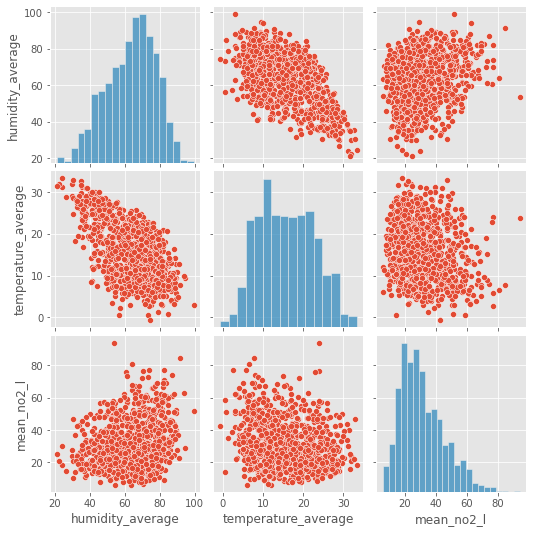

In [10]:
sns.pairplot(all_data[all_data.type == 'sampled'][['humidity_average', 'temperature_average', 'mean_no2_l']].sample(1000))
plt.show()

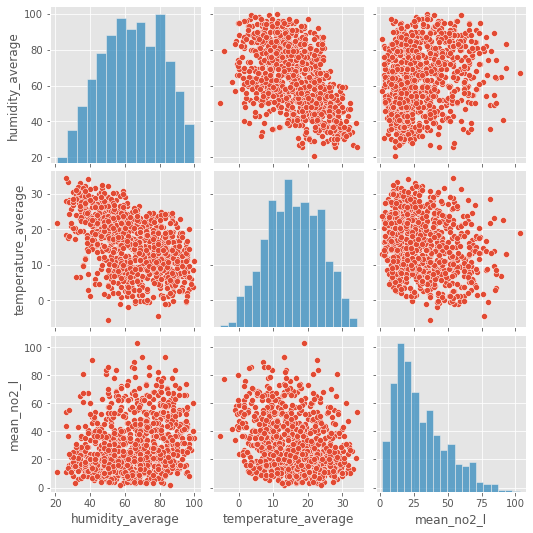

In [11]:
sns.pairplot(all_data[all_data.type == 'original'][['humidity_average', 'temperature_average', 'mean_no2_l']].sample(1000))
plt.show()